Iteration:      1,   Func. Count:      6,   Neg. LLF: 255371763043335.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 591940063.6577182
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4030451034717.2773
Iteration:      4,   Func. Count:     33,   Neg. LLF: 16918.159911343362
Iteration:      5,   Func. Count:     41,   Neg. LLF: 7492.52585911119
Iteration:      6,   Func. Count:     47,   Neg. LLF: 7491.790251838206
Iteration:      7,   Func. Count:     52,   Neg. LLF: 7491.789712831036
Iteration:      8,   Func. Count:     57,   Neg. LLF: 7491.789708734473
Iteration:      9,   Func. Count:     61,   Neg. LLF: 7491.789708736768
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7491.789708734473
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 9


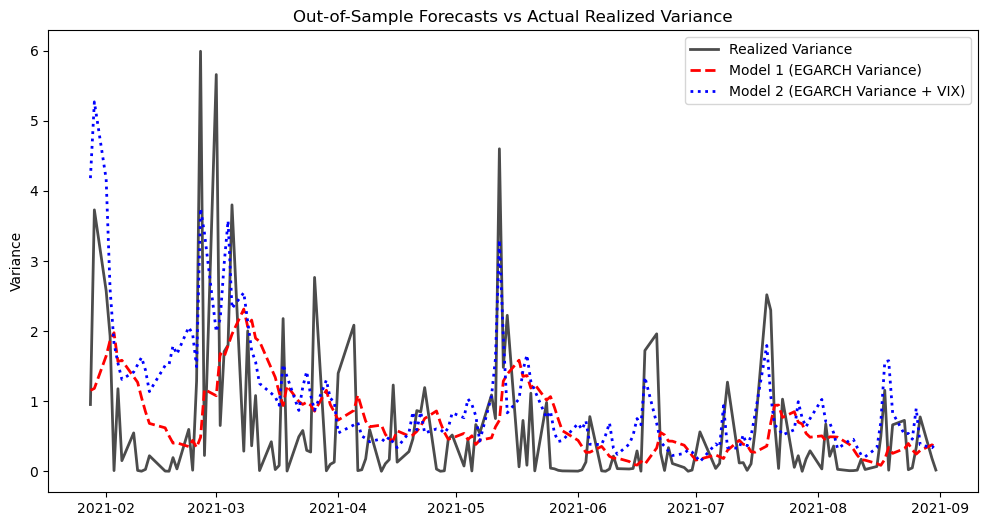

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Download S&P 500 and VIX data from Yahoo Finance
sp500 = yf.download('^GSPC', start='2000-01-01', end='2021-09-01', progress=False)
vix = yf.download('^VIX', start='2000-01-01', end='2021-09-01', progress=False)

# Calculate daily returns for S&P 500 index
sp500['SP500_Returns'] = 100 * sp500['Adj Close'].pct_change().dropna()

# Calculate realized variance (squared returns)
sp500['Realized_Variance'] = sp500['SP500_Returns']**2

# Merge S&P 500 returns and VIX data
data = pd.merge(sp500, vix['Adj Close'], left_index=True, right_index=True, how='inner')
data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP500_Returns', 'Realized_Variance', 'VIX']
# data['VIX'] = data['VIX'].shift(1)  # Use lagged VIX
data = data.dropna()
data['VIX'] = data["VIX"]**2

# Fit the EGARCH(1,1) model
egarch_model = arch_model(data['SP500_Returns'], vol='EGARCH', p=1, q=1)
egarch_results = egarch_model.fit()

# Obtain EGARCH variance estimates
data['EGARCH_Variance'] = egarch_results.conditional_volatility**2

# Split the data into training and testing sets
train_data = data.iloc[:-150]  # Use all data except the last 252 days (approximately one year) for training
test_data = data.iloc[-150:]   # Use the last 252 days for testing

# Model 1: Realized variance vs EGARCH variance
X1_train = train_data[['EGARCH_Variance']]
X1_train = sm.add_constant(X1_train)
y_train = train_data['Realized_Variance']

model1 = sm.OLS(y_train, X1_train)
results1 = model1.fit()

# Model 2: Realized variance vs EGARCH variance and VIX level
X2_train = train_data[['EGARCH_Variance', 'VIX']]
X2_train = sm.add_constant(X2_train)

model2 = sm.OLS(y_train, X2_train)
results2 = model2.fit()

# Out-of-sample forecasts
X1_test = test_data[['EGARCH_Variance']]
X1_test = sm.add_constant(X1_test)
y_test = test_data['Realized_Variance']

X2_test = test_data[['EGARCH_Variance', 'VIX']]
X2_test = sm.add_constant(X2_test)

y_pred_model1 = results1.predict(X1_test)
y_pred_model2 = results2.predict(X2_test)

# Plot the out-of-sample forecasts against the actual realized variance
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label="Realized Variance", linewidth=2, color="black", alpha=0.7)
plt.plot(test_data.index, y_pred_model1, label="Model 1 (EGARCH Variance)", linestyle="--", linewidth=2, color="red")
plt.plot(test_data.index, y_pred_model2, label="Model 2 (EGARCH Variance + VIX)", linestyle=":", linewidth=2, color="blue")

plt.ylabel("Variance")
plt.legend()
plt.title("Out-of-Sample Forecasts vs Actual Realized Variance")
plt.show()

Showing VIX against Realized Variance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


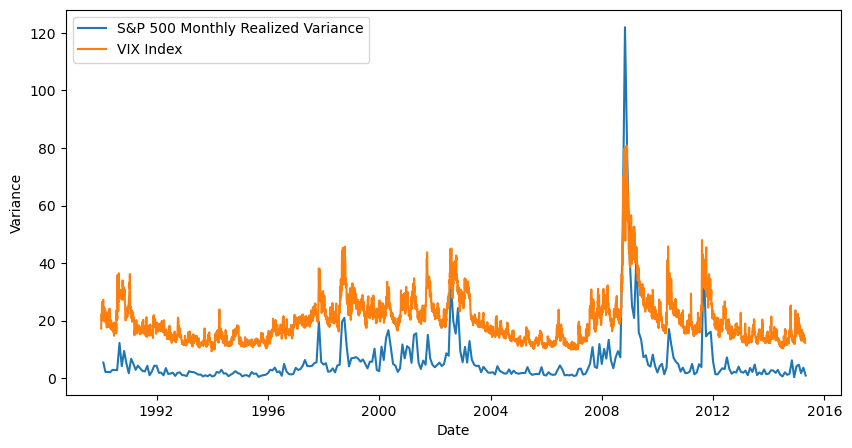

In [4]:

# Download S&P 500 daily returns data
ticker = "^GSPC"
start_date = "1990-01-01"
end_date = "2015-04-25"
sp500 = yf.download(ticker, start=start_date, end=end_date)

# Download VIX index data
vix_ticker = "^VIX"
vix = yf.download(vix_ticker, start=start_date, end=end_date)
daily_var = sp500["Adj Close"].pct_change()**2

# Calculate monthly realized variance
monthly_var = (daily_var).resample('M').sum() * (252/12) *100

# Plot monthly realized variance and VIX index
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(monthly_var.index, monthly_var.values, label='S&P 500 Monthly Realized Variance')
ax.plot(vix.index, vix['Adj Close'], label='VIX Index')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Variance')
plt.show()


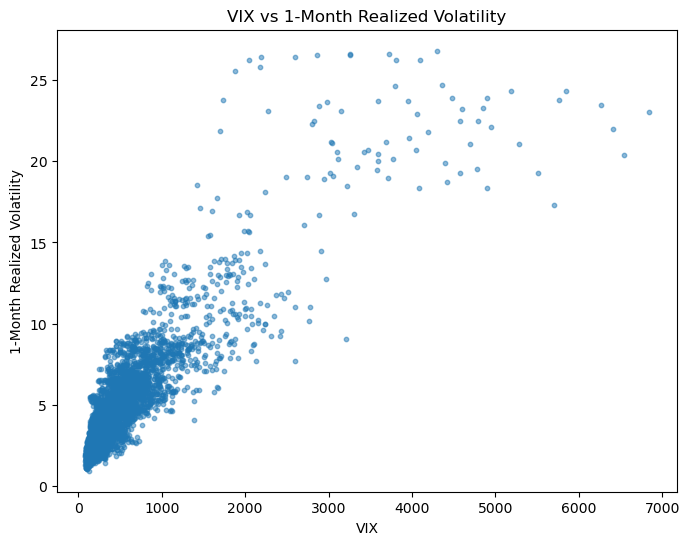

6837.636503759772

In [13]:
# Calculate 1-month realized volatility (20 trading days)
data['1M_Realized_Volatility'] = data['SP500_Returns'].rolling(window=20).apply(lambda x: np.sqrt(np.sum(x**2)))

# Plot VIX vs 1-month realized volatility
plt.figure(figsize=(8, 6))
plt.scatter(data['VIX'], data['1M_Realized_Volatility'], s=10, alpha=0.5)
plt.xlabel("VIX")
plt.ylabel("1-Month Realized Volatility")
plt.title("VIX vs 1-Month Realized Volatility")
plt.show()